In [1]:
import os
import cv2
import numpy as np
import math
import sys

import matplotlib.pyplot as plt
%matplotlib inline


################################
def rgb2gray(rgb):
    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    return gray

################################
import pandas 
# opencv coordinates: origin 0,0 is at top left corner
df = pandas.read_csv('muct76-opencv.csv', header=0, usecols=np.arange(2,154), dtype=float)

X = df.iloc[:, ::2].values
Y = df.iloc[:, 1::2].values

print(X.shape, Y.shape)

df.head()

################################
def draw_shape(img, points, color, closed=False):
    #print(points)
    imgout = img.copy()
    prev_point = points[0]
    for p in points[1:,:]:
        cv2.line(imgout, tuple(prev_point), tuple(p), 
                 color=color, thickness=2)
        prev_point = p
    if closed:
        cv2.line(imgout, tuple(prev_point), tuple(points[0,:]), 
                 color=color, thickness=2)
        
    return imgout

def genMask(src, tri):
    mask = np.zeros(src.shape, dtype = src.dtype)
    cv2.fillConvexPoly(mask, np.int32(tri), (1.0, 1.0, 1.0), 16, 0);
    return mask

(7510, 76) (7510, 76)


In [2]:
################################
# Apply affine transform calculated using srcTri and dstTri to src and
# output an image of size.
def applyAffineTransform(src, srcTri, dstTri, size) :
    
    # Given a pair of triangles, find the affine transform.
    warpMat = cv2.getAffineTransform( np.float32(srcTri), np.float32(dstTri) )
    
    #rbound = cv2.boundingRect(np.float32([dstTri]))
    #print(rbound)
    #size = (rbound[2], rbound[3])
    # Apply the Affine Transform just found to the src image
    dst = cv2.warpAffine( src, warpMat, (size[0], size[1]), None, flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT_101 )

    return dst

################################
# Warps and alpha blends triangular regions from img1 and img2 to img
def warpTriangle(img1, img2, t1, t2) :

    # Find bounding rectangle for each triangle
    r1 = cv2.boundingRect(np.float32([t1]))
    r2 = cv2.boundingRect(np.float32([t2]))

    # Offset points by left top corner of the respective rectangles
    t1Rect = [] 
    t2Rect = []
    t2RectInt = []

    for i in xrange(0, 3):
        t1Rect.append(((t1[i][0] - r1[0]),(t1[i][1] - r1[1])))
        t2Rect.append(((t2[i][0] - r2[0]),(t2[i][1] - r2[1])))
        t2RectInt.append(((t2[i][0] - r2[0]),(t2[i][1] - r2[1])))


    # Get mask by filling triangle
    mask = np.zeros((r2[3], r2[2], 3), dtype = np.float32)
    cv2.fillConvexPoly(mask, np.int32(t2RectInt), (1.0, 1.0, 1.0), 16, 0);

    # Apply warpImage to small rectangular patches
    img1Rect = img1[r1[1]:r1[1] + r1[3], r1[0]:r1[0] + r1[2]]
    #img2Rect = np.zeros((r2[3], r2[2]), dtype = img1Rect.dtype)
    
    size = (r2[2], r2[3])

    img2Rect = applyAffineTransform(img1Rect, t1Rect, t2Rect, size)
    
    img2Rect = img2Rect * mask

    # Copy triangular region of the rectangular patch to the output image
    img2[r2[1]:r2[1]+r2[3], r2[0]:r2[0]+r2[2]] = \
            img2[r2[1]:r2[1]+r2[3], r2[0]:r2[0]+r2[2]] \
            * ( (1.0, 1.0, 1.0) - mask )
     
    img2[r2[1]:r2[1]+r2[3], r2[0]:r2[0]+r2[2]] = \
            img2[r2[1]:r2[1]+r2[3], r2[0]:r2[0]+r2[2]] + img2Rect 


################################
# Check if a point is inside a rectangle
def rectContains(rect, point) :
    if point[0] < rect[0] :
        return False
    elif point[1] < rect[1] :
        return False
    elif point[0] > rect[0] + rect[2] :
        return False
    elif point[1] > rect[1] + rect[3] :
        return False
    return True


#calculate delanauy triangle
def calculateDelaunayTriangles(rect, points):
    #create subdiv
    subdiv = cv2.Subdiv2D(rect);
    
    # Insert points into subdiv
    for p in points:
        subdiv.insert(p) 
    
    triangleList = subdiv.getTriangleList();
    
    delaunayTri = []
    
    pt = []    
    
    count= 0    
    
    for t in triangleList:        
        pt.append((t[0], t[1]))
        pt.append((t[2], t[3]))
        pt.append((t[4], t[5]))
        
        pt1 = (t[0], t[1])
        pt2 = (t[2], t[3])
        pt3 = (t[4], t[5])        
        
        if rectContains(rect, pt1) and rectContains(rect, pt2) and rectContains(rect, pt3):
            count = count + 1 
            ind = []
            for j in range(0, 3):
                for k in range(0, len(points)):                    
                    if(abs(pt[j][0] - points[k][0]) < 1.0 and abs(pt[j][1] - points[k][1]) < 1.0):
                        ind.append(k)                            
            if len(ind) == 3:                                                
                delaunayTri.append((ind[0], ind[1], ind[2]))
        
        pt = []        
            
    
    return delaunayTri

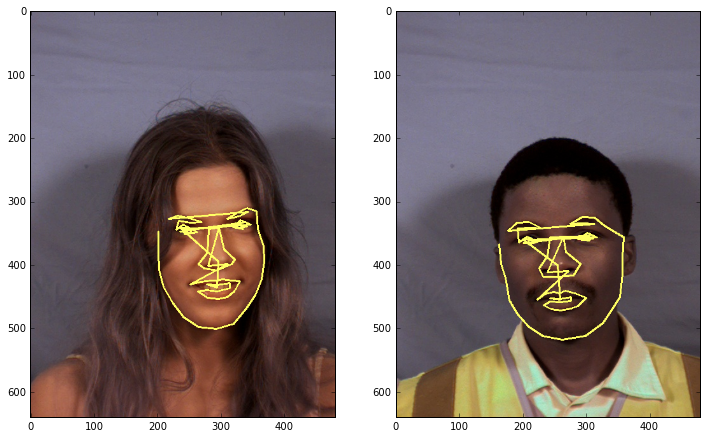

In [3]:

img1 = cv2.imread('figs/front-image.jpg')
img2 = cv2.imread('figs/front-image-2.jpg')

points1 = np.vstack ((X[0,:], Y[0,:])).T    # i000qa-fn
points2 = np.vstack ((X[15,:], Y[15,:])).T  # i001qa-mn

points1 = points1.astype(int)
points2 = points2.astype(int)

### Plot
plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
img1shape = draw_shape(img1, points1[:,:], color=(100,255,255))
plt.imshow(cv2.cvtColor(img1shape, cv2.COLOR_BGR2RGB))
plt.subplot(1,2,2)
img2shape = draw_shape(img2, points2[:,:], color=(100,255,255))
plt.imshow(cv2.cvtColor(img2shape, cv2.COLOR_BGR2RGB))
plt.show()

(18, 2)
(17, 2)


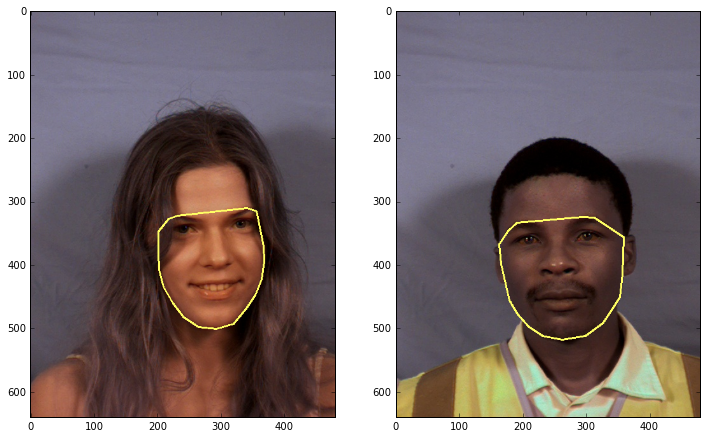

In [18]:
hull1 = []
hull2 = []

hullIndex1 = cv2.convexHull(np.array(points1), returnPoints = False)
hullIndex2 = cv2.convexHull(np.array(points2), returnPoints = False)

for i in range(0, len(hullIndex1)):
    hull1.append(tuple(points1[hullIndex1.flatten()[i]]))

for i in range(0, len(hullIndex2)):
    hull2.append(tuple(points2[hullIndex2.flatten()[i]]))

hull1arr = np.array(hull1)
hull2arr = np.array(hull2)

print(hull1arr.shape)
print(hull2arr.shape)

### Plot
plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
img1shape = draw_shape(img1, hull1arr, color=(100,255,255), closed=True)
plt.imshow(cv2.cvtColor(img1shape, cv2.COLOR_BGR2RGB))
plt.subplot(1,2,2)
img2shape = draw_shape(img2, hull2arr, color=(100,255,255), closed=True)
plt.imshow(cv2.cvtColor(img2shape, cv2.COLOR_BGR2RGB))
plt.show()

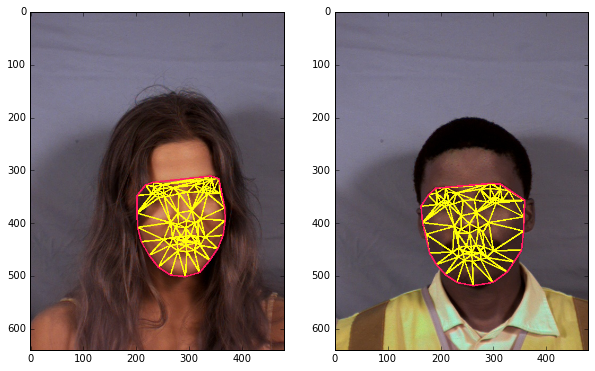

In [19]:
sizeImg1 = img1.shape    
rect = (0, 0, sizeImg1[1], sizeImg1[0])

trilist = calculateDelaunayTriangles(rect, tuple(map(tuple, points1)))

tmp1 = img1.copy()
tmp2 = img2.copy()


for tri in trilist:
    tp1 = points1[tri, :]
    tp2 = points2[tri, :]
    tmp1 = draw_shape(tmp1, tp1, (10,255,255), True)
    tmp2 = draw_shape(tmp2, tp2, (10,255,255), True)
    
tmp1 = draw_shape(tmp1, hull1arr, color=(100,25,255), closed=True)
tmp2 = draw_shape(tmp2, hull2arr, color=(100,25,255), closed=True)

plt.figure(figsize=(10,16))
plt.subplot(1,2, 1)
plt.imshow(cv2.cvtColor(tmp1, cv2.COLOR_BGR2RGB))
plt.subplot(1,2, 2)
plt.imshow(cv2.cvtColor(tmp2, cv2.COLOR_BGR2RGB))
plt.show()

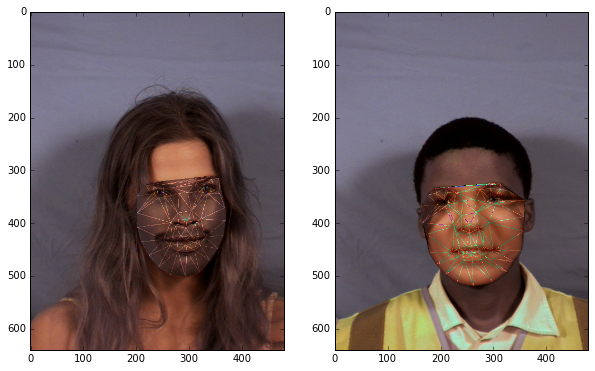

In [20]:
face1on2 = np.zeros(shape=img2.shape, dtype=img2.dtype)
face2on1 = np.zeros(shape=img1.shape, dtype=img1.dtype)

tmp1 = img1.copy()
tmp2 = img2.copy()

for tri in trilist:
    tp1 = points1[np.array(tri),:]
    tp2 = points2[np.array(tri),:]
    
    res1 = applyAffineTransform(img1, tp1, tp2, (img2.shape[1], img2.shape[0]))
    face1on2 += res1 * genMask(res1, tp2)
    
    res2 = applyAffineTransform(img2, tp2, tp1, (img1.shape[1], img1.shape[0]))
    face2on1 += res2 * genMask(res2, tp1)
    
mask1 = np.array((1,1,1), dtype=img1.dtype) - genMask(img1, hull1)
mask2 = np.array((1,1,1), dtype=img2.dtype) - genMask(img2, hull2)

plt.figure(figsize=(10,16))
plt.subplot(1,2, 1)
plt.imshow(cv2.cvtColor(img1*mask1 + face2on1 , cv2.COLOR_BGR2RGB))
plt.subplot(1,2, 2)
plt.imshow(cv2.cvtColor(img2*mask2 + face1on2, cv2.COLOR_BGR2RGB))
plt.show()